**画像生成タスクとして、GANのGenerator部分をVAEにしてみる**

In [ ]:
from datetime import datetime
import IPython
import os
import pickle
import PIL
import pprint
import random

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchvision
from tqdm.notebook import tqdm
random.seed(3407)
np.random.seed(3407)
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
torch.backends.cudnn.benchmark = True  # ループ内で順伝播や逆伝播が同じ計算手法ならば処理を高速化させる

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**データ収集(今回はデータとして、HuggingFaceにあるアニメ顔画像を使う)**

In [ ]:
# HuggingFaceにあるアニメ顔画像DatasetDictをロード
hugging_face_dataset_dict = datasets.load_dataset("DrishtiSharma/Anime-Face-Dataset",
                                                  trust_remote_code=True)
# ロードしたDatasetDictからDataset(DatasetDictにあるtrainのDatasetのみ)を取得
ds = hugging_face_dataset_dict["train"]
# Datasetを確認
print(ds)
# Dataset内のデータのタイプを確認
print(ds.features)
# 一部のデータは白黒画像などで3階数テンソルではないので、そのデータを弾く
RGB_row_list_1 = [id_1 for id_1 in range(ds.num_rows) if len(np.array(ds[id_1]["image"]).shape) == 3]  # 3階数テンソルである画像データの行番号を取得
ds = ds.select(indices=RGB_row_list_1)  # その行番号のデータだけを取得
# 一部のデータは3チャンネルでなく、4チャンネル(αチャンネルを持つ)なので、そのデータを弾く
RGB_row_list_2 = [id_2 for id_2 in range(ds.num_rows) if np.array(ds[id_2]["image"]).shape[2] == 3]  # チャンネル数が3である画像データの行番号を取得
ds = ds.select(indices=RGB_row_list_2)  # その行番号のデータだけを取得
# データを確認
print(ds.num_rows)
print(len(ds))  # 後続でのDataset処理を踏まえて、lenでもデータ数を取得出来る事を確認
print(ds[100]["image"])
IPython.display.display(ds[100]["image"])
print(np.array(ds[100]["image"]).shape)

In [ ]:
fig = plt.figure(figsize=(10, 12))
for i in range(30):
    fig.add_subplot(6, 5, i+1)
    plt.imshow(np.array(ds[i]["image"]))
    plt.axis("off")
plt.subplots_adjust(wspace=0,
                    hspace=0)
plt.show()

**訓練データ(正解ラベル無しデータ)を準備**

In [ ]:
# 生成タスクなので、validationデータでの評価を行わないため、validationデータは作らない
num_data = ds.num_rows
# データの1%(約600個)のデータを使う
# train_image_ds = ds[:int(num_data*0.01)]["image"]
train_image_ds = ds[1:4]["image"]
for i in range(len(train_image_ds)):
    print(train_image_ds[i])
    IPython.display.display(train_image_ds[i])

**前処理(データ拡張含む)の準備**

In [ ]:
# データ拡張(Data Augmentation)を定義
image_transform_method = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(96, 96)),
                                                         torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                                         torchvision.transforms.RandomRotation(degrees=(-10, 10))])

In [ ]:
# 正規化とテンソル化を定義
def normalize_and_tensorize(PIL_image):
    array_image = np.array(PIL_image).transpose(2, 0, 1)  # PILをnumpyにして、形状を(チャンネル, 縦, 横)
    normalize_array_image = array_image / 255  # 255で割って正規化
    normalize_tensor_image = torch.FloatTensor(normalize_array_image)  # arrayをtensorにする
    return normalize_tensor_image

In [ ]:
# Datasetクラスを定義
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, image_datas, data_augmentation, tensorize):
        super().__init__()
        self.image_datas = image_datas
        self.data_augmentation = data_augmentation
        self.tensorize = tensorize

    def __len__(self):
        return len(self.image_datas)

    def __getitem__(self, idx):
        image = self.image_datas[idx]
        augmentation_image = self.data_augmentation(image)
        augmentation_tensor_image = self.tensorize(PIL_image=augmentation_image)
        return augmentation_tensor_image

**前処理**

In [ ]:
train_dataset = MyDataset(image_datas=train_image_ds,
                          data_augmentation=image_transform_method,
                          tensorize=normalize_and_tensorize)

In [ ]:
train_dataset_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                       batch_size=50,
                                                       shuffle=True)

**GAN including VAEモデルを作成**

Generator側(VAEモデル)

In [ ]:
class MyVAEEncoderConvLayer(torch.nn.Module):
    def __init__(self, input_n, output_n):
        super().__init__()
        self.layer_1 = torch.nn.Conv2d(in_channels=input_n,  # チャンネル数を指定の値にして、解像度を半分にする
                                       out_channels=output_n,
                                       kernel_size=2,
                                       stride=2,
                                       padding=0)
        self.layer_2 = torch.nn.BatchNorm2d(num_features=output_n)

    def forward(self, in_data_layer):
        out_data_layer_1 = self.layer_1(in_data_layer)
        out_data_layer_2 = torch.nn.functional.leaky_relu(input=self.layer_2(out_data_layer_1),  # BatchNormの後にLeakyReLU
                                                          negative_slope=0.01)
        return out_data_layer_2

In [ ]:
class MyVAEEncoder(torch.nn.Module):
    def __init__(self, in_num, out_num, hw_size):
        super().__init__()
        self.layer_1 = MyVAEEncoderConvLayer(input_n=in_num,
                                             output_n=32)
        self.layer_2 = MyVAEEncoderConvLayer(input_n=32,
                                             output_n=64)
        self.layer_3 = MyVAEEncoderConvLayer(input_n=64,
                                             output_n=128)
        self.layer_4 = MyVAEEncoderConvLayer(input_n=128,
                                             output_n=256)
        self.layer_5 = MyVAEEncoderConvLayer(input_n=256,
                                             output_n=512)
        self.layer_6_mu = torch.nn.Linear(in_features=512*int(hw_size/(2**5))*int(hw_size/(2**5)),
                                          out_features=out_num)  # out_num(z_dim)は256
        self.layer_6_sigma = torch.nn.Linear(in_features=512*int(hw_size/(2**5))*int(hw_size/(2**5)),
                                             out_features=out_num)  # out_num(z_dim)は256

    def forward(self, in_data_encoder):
        # print("en_in", in_data_encoder.shape)  # (50, 3, 96, 96)
        out_data_layer_1 = self.layer_1(in_data_encoder)
        # print("en_1", out_data_layer_1.shape)  # (50, 32, 48, 48)
        out_data_layer_2 = self.layer_2(out_data_layer_1)
        # print("en_2", out_data_layer_2.shape)  # (50, 64, 24, 24)
        out_data_layer_3 = self.layer_3(out_data_layer_2)
        # print("en_3", out_data_layer_3.shape)  # (50, 128, 12, 12)
        out_data_layer_4 = self.layer_4(out_data_layer_3)
        # print("en_4", out_data_layer_4.shape)  # (50, 256, 6, 6)
        out_data_layer_5 = self.layer_5(out_data_layer_4)
        # print("en_5", out_data_layer_5.shape)  # (50, 512, 3, 3)
        c = out_data_layer_5.shape[1]
        h = out_data_layer_5.shape[2]
        w = out_data_layer_5.shape[3]
        in_data_layer_6 = out_data_layer_5.view(-1, c*h*w)
        # print("en_in5", in_data_layer_5.shape)  # (50, 4608)
        mu = self.layer_6_mu(in_data_layer_6)  # 潜在変数のネタ1(μ)
        # print("mu", mu.shape)  # (50, 256)
        sigma = self.layer_6_sigma(in_data_layer_6)  # 潜在変数のネタ2(σ)
        # print("sigma", sigma.shape)  # (50, 256)
        epsilon = torch.randn_like(mu)  # 潜在変数のネタ3(ε)で、正規分布の乱数
        # print("epsilon", epsilon.shape)  # (50, 256)
        z = mu + torch.exp(sigma/2) * epsilon  # 再パラメータ化トリックで算出した潜在変数(z)
        # print("z", z.shape)  # (50, 256)
        return z, mu, sigma

In [ ]:
class MyVAEDecoderUpConvLayer(torch.nn.Module):
    def __init__(self, input_n, output_n):
        super().__init__()
        self.layer_1 = torch.nn.ConvTranspose2d(in_channels=input_n,  # チャンネル数を指定の値にして、解像度を2倍にする
                                                out_channels=output_n,
                                                kernel_size=3,
                                                stride=2,
                                                padding=1,
                                                output_padding=1)
        self.layer_2 = torch.nn.BatchNorm2d(num_features=output_n)

    def forward(self, in_data_layer):
        out_data_layer_1 = self.layer_1(in_data_layer)
        out_data_layer_2 = torch.nn.functional.leaky_relu(input=self.layer_2(out_data_layer_1),  # BatchNormの後にLeakyReLU
                                                          negative_slope=0.01)
        return out_data_layer_2

In [ ]:
class MyVAEDecoder(torch.nn.Module):
    def __init__(self, in_num, out_num, hw_size):
        super().__init__()
        self.hw_size = int(hw_size/2**5)  # 96/2^5=3
        self.layer_1 = torch.nn.Linear(in_features=in_num,  # in_num(z_dim)は256
                                       out_features=512*self.hw_size*self.hw_size)
        self.layer_2 = MyVAEDecoderUpConvLayer(input_n=512,
                                               output_n=256)
        self.layer_3 = MyVAEDecoderUpConvLayer(input_n=256,
                                               output_n=128)
        self.layer_4 = MyVAEDecoderUpConvLayer(input_n=128,
                                               output_n=64)
        self.layer_5 = MyVAEDecoderUpConvLayer(input_n=64,
                                               output_n=32)
        self.layer_6 = MyVAEDecoderUpConvLayer(input_n=32,
                                               output_n=3)
        self.layer_7 = torch.nn.Conv2d(in_channels=3,
                                       out_channels=out_num,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

    def forward(self, in_data_decoder):
        # print("de_in", in_data_decoder.shape)  # (50, 256)
        out_data_layer_1 = torch.nn.functional.leaky_relu(input=self.layer_1(in_data_decoder),  # 全結合層の後にLeakyReLU
                                                          negative_slope=0.01)
        # print("de_1", out_data_layer_1.shape)  # (50, 4608)
        in_data_layer_2 = out_data_layer_1.view(-1, 512, self.hw_size, self.hw_size)
        # print("de_in2", in_data_layer_2.shape)  # (50, 512, 3, 3)
        out_data_layer_2 = self.layer_2(in_data_layer_2)
        # print("de_2", out_data_layer_2.shape)  # (50, 256, 6, 6)
        out_data_layer_3 = self.layer_3(out_data_layer_2)
        # print("de_3", out_data_layer_3.shape)  # (50, 128, 12, 12)
        out_data_layer_4 = self.layer_4(out_data_layer_3)
        # print("de_4", out_data_layer_4.shape)  # (50, 64, 24, 24)
        out_data_layer_5 = self.layer_5(out_data_layer_4)
        # print("de_5", out_data_layer_5.shape)  # (50, 32, 48, 48)
        out_data_layer_6 = self.layer_6(out_data_layer_5)
        # print("de_6", out_data_layer_6.shape)  # (50, 3, 96, 96)
        out_data_layer_7 = self.layer_7(out_data_layer_6)
        # print("de_7", out_data_layer_7.shape)  # (50, 3, 96, 96)
        return out_data_layer_7

In [ ]:
class MyGenerator(torch.nn.Module):
    def __init__(self, in_dim, z_dim, out_dim, size):
        super().__init__()
        self.layer_encoder = MyVAEEncoder(in_num=in_dim,
                                          out_num=z_dim,
                                          hw_size=size)
        self.layer_decoder = MyVAEDecoder(in_num=z_dim,
                                          out_num=out_dim,
                                          hw_size=size)

    def forward(self, in_data):
        z, mu, sigma = self.layer_encoder(in_data)
        out_data = self.layer_decoder(z)
        return out_data, z, mu, sigma

    def generate_image(self, in_tensor_data):
        out_data = self.layer_decoder(in_tensor_data)
        out_data_sigmoid = torch.sigmoid(out_data)  # テンソルの要素の値を0～1にするため
        return out_data_sigmoid

Discriminator側

In [ ]:
class MyDiscriminatorConvLayer(torch.nn.Module):
    def __init__(self, in_num, out_num):
        super().__init__()
        self.layer_1 = torch.nn.Conv2d(in_channels=in_num,  # チャンネル数を指定の値にして、解像度を半分にする
                                       out_channels=out_num,
                                       kernel_size=2,
                                       stride=2,
                                       padding=0)
        self.layer_2 = torch.nn.BatchNorm2d(num_features=out_num)

    def forward(self, in_data):
        out_data_layer_1 = self.layer_1(in_data)
        out_data_layer_2 = torch.nn.functional.leaky_relu(input=self.layer_2(out_data_layer_1),
                                                          negative_slope=0.01)
        return out_data_layer_2

In [ ]:
class MyDiscriminator(torch.nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.layer_1 = MyDiscriminatorConvLayer(in_num=in_dim,
                                                out_num=32)
        self.layer_2 = MyDiscriminatorConvLayer(in_num=32,
                                                out_num=64)
        self.layer_3 = MyDiscriminatorConvLayer(in_num=64,
                                                out_num=128)
        self.layer_4 = MyDiscriminatorConvLayer(in_num=128,
                                                out_num=256)
        self.layer_5 = MyDiscriminatorConvLayer(in_num=256,
                                                out_num=512)
        self.layer_6 = torch.nn.Conv2d(in_channels=512,  # チャンネル数を指定の値にして、解像度はそのまま
                                       out_channels=1,
                                       kernel_size=1,
                                       stride=1,
                                       padding=0)

    def forward(self, in_data):
        # print("discriminator_in", in_data.shape)  # (30, 3, 96, 96)
        out_data_layer_1 = self.layer_1(in_data)
        # print("discriminator_1", out_data_layer_1.shape)  # (30, 32, 48, 48)
        out_data_layer_2 = self.layer_2(out_data_layer_1)
        # print("discriminator_2", out_data_layer_2.shape)  # (30, 64, 24, 24)
        out_data_layer_3 = self.layer_3(out_data_layer_2)
        # print("discriminator_3", out_data_layer_3.shape)  # (30, 128, 12, 12)
        out_data_layer_4 = self.layer_4(out_data_layer_3)
        # print("discriminator_4", out_data_layer_4.shape)  # (30, 256, 6, 6)
        out_data_layer_5 = self.layer_5(out_data_layer_4)
        # print("discriminator_5", out_data_layer_5.shape)  # (30, 512, 3, 3)
        out_data_layer_6 = self.layer_6(out_data_layer_5)
        # print("discriminator_6", out_data_layer_6.shape)  # (30, 1, 3, 3)
        return out_data_layer_6

**モデル、損失関数、最適化アルゴリズム**

In [ ]:
nn_model_G = MyGenerator(in_dim=3,
                         z_dim=256,
                         out_dim=3,
                         size=96).to(device)  # GPUへ
nn_model_D = MyDiscriminator(in_dim=3).to(device)  # GPUへ
loss_BCE_for_GAN = torch.nn.BCEWithLogitsLoss()  # BinaryCrossEntropylossにSigmoidを組み合わせたもの # GAN向け
coefficient = 100  # 損失値の計算の時にL1Lossに掛ける係数
loss_MAE = torch.nn.L1Loss()  # MeanAbsoluteError
loss_BCE_for_VAE = torch.nn.BCEWithLogitsLoss(reduction="sum")  # BinaryCrossEntropylossにSigmoidを組み合わせたもの # VAE向け
optimizer_G = torch.optim.Adam(params=nn_model_G.parameters(),
                               lr=0.0001)  # 0.001ではGANのせいか3エポックで損失値がNaNになったので、学習率を下げて損失の発散を防ぐ
optimizer_D = torch.optim.Adam(params=nn_model_D.parameters(),
                               lr=0.0001)

In [ ]:
torchinfo.summary(model=nn_model_G,
                  input_size=(50, 3, 96, 96),
                  depth=5)

Layer (type:depth-idx)                   Output Shape              Param #
MyGenerator                              [50, 3, 96, 96]           --
├─MyVAEEncoder: 1-1                      [50, 256]                 --
│    └─MyVAEEncoderConvLayer: 2-1        [50, 32, 48, 48]          --
│    │    └─Conv2d: 3-1                  [50, 32, 48, 48]          416
│    │    └─BatchNorm2d: 3-2             [50, 32, 48, 48]          64
│    └─MyVAEEncoderConvLayer: 2-2        [50, 64, 24, 24]          --
│    │    └─Conv2d: 3-3                  [50, 64, 24, 24]          8,256
│    │    └─BatchNorm2d: 3-4             [50, 64, 24, 24]          128
│    └─MyVAEEncoderConvLayer: 2-3        [50, 128, 12, 12]         --
│    │    └─Conv2d: 3-5                  [50, 128, 12, 12]         32,896
│    │    └─BatchNorm2d: 3-6             [50, 128, 12, 12]         256
│    └─MyVAEEncoderConvLayer: 2-4        [50, 256, 6, 6]           --
│    │    └─Conv2d: 3-7                  [50, 256, 6, 6]           131,328


In [ ]:
torchinfo.summary(model=nn_model_D,
                  input_size=(50, 3, 96, 96),
                  depth=5)

Layer (type:depth-idx)                   Output Shape              Param #
MyDiscriminator                          [50, 1, 3, 3]             --
├─MyDiscriminatorConvLayer: 1-1          [50, 32, 48, 48]          --
│    └─Conv2d: 2-1                       [50, 32, 48, 48]          416
│    └─BatchNorm2d: 2-2                  [50, 32, 48, 48]          64
├─MyDiscriminatorConvLayer: 1-2          [50, 64, 24, 24]          --
│    └─Conv2d: 2-3                       [50, 64, 24, 24]          8,256
│    └─BatchNorm2d: 2-4                  [50, 64, 24, 24]          128
├─MyDiscriminatorConvLayer: 1-3          [50, 128, 12, 12]         --
│    └─Conv2d: 2-5                       [50, 128, 12, 12]         32,896
│    └─BatchNorm2d: 2-6                  [50, 128, 12, 12]         256
├─MyDiscriminatorConvLayer: 1-4          [50, 256, 6, 6]           --
│    └─Conv2d: 2-7                       [50, 256, 6, 6]           131,328
│    └─BatchNorm2d: 2-8                  [50, 256, 6, 6]           512

**学習**

In [ ]:
FOLDER_NAME = "./GAN_VAE"

In [ ]:
if os.path.isfile(path="{a}/epoch_train_loss_G_total_list.pkl".format(a=FOLDER_NAME)):
    with open(file="{a}/epoch_train_loss_G_total_list.pkl".format(a=FOLDER_NAME), mode="rb") as f:
        epoch_train_loss_G_total_list = pickle.load(file=f)
else:
    epoch_train_loss_G_total_list = []
if os.path.isfile(path="{a}/epoch_train_loss_D_total_list.pkl".format(a=FOLDER_NAME)):
    with open(file="{a}/epoch_train_loss_D_total_list.pkl".format(a=FOLDER_NAME), mode="rb") as f:
        epoch_train_loss_D_total_list = pickle.load(file=f)
else:
    epoch_train_loss_D_total_list = []
if os.path.isfile(path="{a}/epoch_train_z_vector_dict.pkl".format(a=FOLDER_NAME)):
    with open(file="{a}/epoch_train_z_vector_dict.pkl".format(a=FOLDER_NAME), mode="rb") as f:
        epoch_train_z_vector_dict = pickle.load(file=f)
else:
    epoch_train_z_vector_dict = {"face": []}
if os.path.isfile(path="{a}/FineTuning_GAN_VAE_G.model".format(a=FOLDER_NAME)):
    nn_model_G.load_state_dict(state_dict=torch.load(f="{a}/FineTuning_GAN_VAE_G.model".format(a=FOLDER_NAME)))
if os.path.isfile(path="{a}/FineTuning_GAN_VAE_D.model".format(a=FOLDER_NAME)):
    nn_model_D.load_state_dict(state_dict=torch.load(f="{a}/FineTuning_GAN_VAE_D.model".format(a=FOLDER_NAME)))
for epoch in tqdm(range(5000)):
    train_loss_G_total = 0
    train_loss_D_total = 0
    train_z_vector_list = []
    nn_model_G.train()
    nn_model_D.train()
    for train_input_tensor_minibatch in train_dataset_dataloader:
        train_input_tensor_minibatch = train_input_tensor_minibatch.to(device)  # GPUへ
        output_G, z, mu, sigma = nn_model_G(in_data=train_input_tensor_minibatch)  # 訓練データを入力にして、Gから出力
        output_G_copy = output_G.clone()  # G出力をコピー(Gの損失値の算出で使うため)
        output_G_image_detach = torch.sigmoid(output_G.clone()).detach()  # G出力のsigmoidの微分無し(D入力の画像データとして使うため)
        train_z_vector_list.append(z.detach().cpu().numpy())
        output_D_by_G = nn_model_D(in_data=output_G)  # G結果を入力にして、Dから出力
        true_label_for_D = torch.ones(size=output_D_by_G.shape).to(device)  # D正解ラベル(3×3のTrue行列) # GPUへ
        false_label_for_D = torch.zeros(size=output_D_by_G.shape).to(device)  # D外れラベル(3×3のFalse行列) # GPUへ
        # ↓ここからGの学習↓
        loss_G1 = loss_BCE_for_GAN(output_D_by_G,  # Gの損失値1(GAN版) # D出力(G結果入力)とD正解の正誤分類(GとしてはD正解に近づけたい)
                                   true_label_for_D)
        loss_G2 = loss_MAE(output_G,  # Gの損失値2(GAN版) # G出力(正解画像入力)と正解画像のピクセル回帰(Gとしては正解画像に近づけたい)
                           train_input_tensor_minibatch)
        loss_G3 = loss_BCE_for_VAE(output_G_copy,  # Gの損失値3(VAE版) # G出力(正解画像入力)と正解画像のピクセル分類
                                   train_input_tensor_minibatch)
        loss_G4 = -0.5 * torch.sum(1 + sigma - mu**2 - sigma.exp())  # Gの損失値4(VAE版)  # VAE損失関数の正則化項
        loss_G = loss_G1 + (coefficient * loss_G2) + loss_G3 + loss_G4  # Gの損失値
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        train_loss_G_total = train_loss_G_total + loss_G.item()
        # ↑ここまでGの学習↑
        output_D = nn_model_D(in_data=train_input_tensor_minibatch)  # 訓練データを入力にして、Dから出力
        output_D_by_G_image = nn_model_D(in_data=output_G_image_detach)  # G出力画像データを入力にして、Dから出力
        # ↓ここからDの学習
        loss_D1 = loss_BCE_for_GAN(output_D,  # Dの損失値1 # D出力(正解画像入力)とD正解の正誤分類(DとしてはD正解に近づけたい)
                                   true_label_for_D)
        loss_D2 = loss_BCE_for_GAN(output_D_by_G_image,  # Dの損失値2 # D出力(G結果入力)とD外れの正誤分類(DとしてはD外れに近づけたい)
                                   false_label_for_D)
        loss_D = loss_D1 + loss_D2  # Dの損失値
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        train_loss_D_total = train_loss_D_total + loss_D.item()
        # ↑ここまでDの学習↑
    epoch_train_loss_G_total_list.append(train_loss_G_total)
    with open(file="{a}/epoch_train_loss_G_total_list.pkl".format(a=FOLDER_NAME), mode="wb") as f:
        pickle.dump(obj=epoch_train_loss_G_total_list,
                    file=f)
    epoch_train_loss_D_total_list.append(train_loss_D_total)
    with open(file="{a}/epoch_train_loss_D_total_list.pkl".format(a=FOLDER_NAME), mode="wb") as f:
        pickle.dump(obj=epoch_train_loss_D_total_list,
                    file=f)
    epoch_train_z_vector = np.concatenate(train_z_vector_list,
                                          axis=0)
    epoch_train_z_vector_dict["face"].append(epoch_train_z_vector)
    with open(file="{a}/epoch_train_z_vector_dict.pkl".format(a=FOLDER_NAME), mode="wb") as f:
        pickle.dump(obj=epoch_train_z_vector_dict,
                    file=f)
    torch.save(obj=nn_model_G.state_dict(),
               f="{a}/FineTuning_GAN_VAE_G.model".format(a=FOLDER_NAME))
    torch.save(obj=nn_model_D.state_dict(),
               f="{a}/FineTuning_GAN_VAE_D.model".format(a=FOLDER_NAME))

**損失値の推移をグラフ化**

In [ ]:
with open(file="{a}/epoch_train_loss_G_total_list.pkl".format(a=FOLDER_NAME), mode="rb") as f:
    epoch_train_loss_G_total_list = pickle.load(file=f)
with open(file="{a}/epoch_train_loss_D_total_list.pkl".format(a=FOLDER_NAME), mode="rb") as f:
    epoch_train_loss_D_total_list = pickle.load(file=f)

In [ ]:
x_datas = np.arange(1, len(epoch_train_loss_G_total_list)+1, 1)
y_datas_list = [epoch_train_loss_G_total_list,
                epoch_train_loss_D_total_list]
labels = ["Generator",
          "Discriminator"]
colors = list(matplotlib.colors.CSS4_COLORS.values())
random.shuffle(colors)
label2color = colors[:len(labels)]

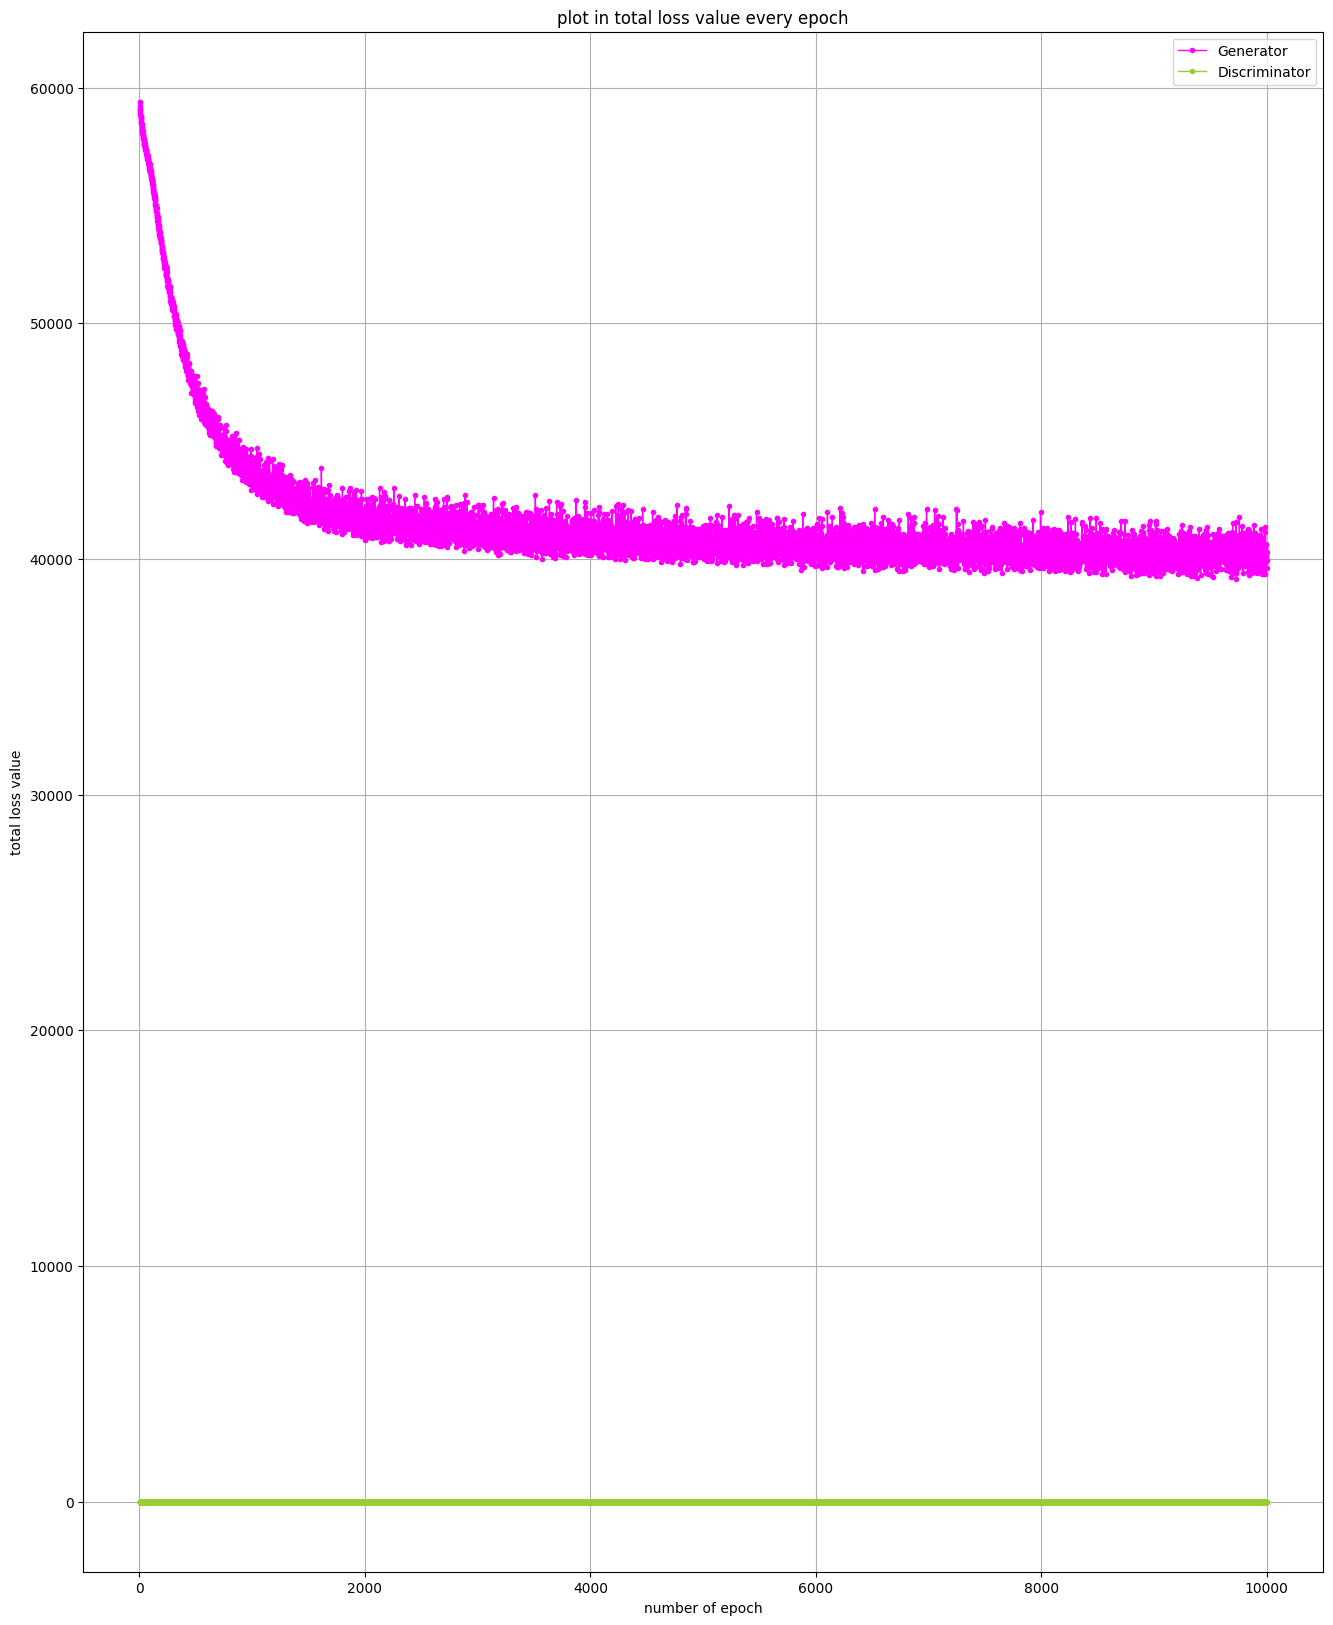

In [ ]:
fig, axes1 = plt.subplots(nrows=1,
                          ncols=1,
                          figsize=(16, 20))
for i, y_datas in enumerate(y_datas_list):
    axes1.plot(x_datas,
               y_datas,
               label=labels[i],
               c=label2color[i],
               marker="o",
               markersize=3,
               linestyle="solid",
               linewidth=1)
    # for j in range(len(y_datas)):
    #     axes1.annotate(text=round(y_datas[j], 3),
    #                    xy=(x_datas[j], y_datas[j]))
axes1.legend()
axes1.set_title("plot in total loss value every epoch")
axes1.set_xlabel("number of epoch")
axes1.set_ylabel("total loss value")
# axes1.set_xticks(ticks=x_datas)
axes1.grid(True)
plt.show()

**最新epoch学習時の潜在変数を使って画像を生成**

In [ ]:
# 画像生成を行うためのDecoder入力データを作成
newest_z_vector = epoch_train_z_vector_dict["face"][-1]
input_decoder_z_vector_list = []
for i in range(100):
    random_vector = np.random.rand(newest_z_vector.shape[0])
    sum_random_value = np.sum(random_vector)
    random_ratio_vector = random_vector / sum_random_value
    input_decoder_z_vector = np.average(a=newest_z_vector,
                                        axis=0,
                                        weights=random_ratio_vector).reshape(1, -1)
    input_decoder_z_vector_list.append(input_decoder_z_vector)
in_data_for_decoder = np.concatenate(input_decoder_z_vector_list,
                                     axis=0)

In [ ]:
# 作成したDecoder入力データを、VAEモデルのDecoderのインプットにして画像生成
if os.path.isfile(path="{a}/FineTuning_GAN_VAE_G.model".format(a=FOLDER_NAME)):
    nn_model_G.load_state_dict(state_dict=torch.load(f="{a}/FineTuning_GAN_VAE_G.model".format(a=FOLDER_NAME)))
nn_model_G.eval()
predict_image_vector_list = []
with torch.no_grad():
    in_tensor_data_for_decoder = torch.FloatTensor(in_data_for_decoder).to(device)
    predict = nn_model_G.generate_image(in_tensor_data=in_tensor_data_for_decoder)
    predict_array = predict.detach().cpu().numpy()
    predict_array_for_PIL = predict_array.transpose(0, 2, 3, 1)
    predict_denormalized_array_for_PIL = (predict_array_for_PIL * 255).astype(dtype=np.uint8)
    for i in range(predict_denormalized_array_for_PIL.shape[0]):
        # r = predict_denormalized_array_for_PIL[i][:, :, 0]
        # print(r.shape)  # (96, 96)
        # g = predict_denormalized_array_for_PIL[i][:, :, 1]
        # print(g.shape)  # (96, 96)
        # b = predict_denormalized_array_for_PIL[i][:, :, 2]
        # print(b.shape)  # (96, 96)
        # rgb = np.dstack([b, g, r])
        # print(rgb.shape)  # (96, 96, 3)
        # predict_image_vector_list.append(rgb)
        predict_image_vector_list.append(predict_denormalized_array_for_PIL[i])
fig = plt.figure(figsize=(16, 16))
for j in range(len(predict_image_vector_list)):
    fig.add_subplot(10, 10, j+1)
    plt.imshow(predict_image_vector_list[j])
    plt.axis("off")
plt.subplots_adjust(wspace=0,
                    hspace=0)
plt.show()